In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import gc
import random
import warnings
import pickle
import importlib
warnings.filterwarnings(action='ignore')
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
torch.manual_seed(1015)
# define 'device' to upload tensor in gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import sklearn
from sklearn.neighbors import KNeighborsRegressor

# 상위 폴더에서 module을 import하기 위해 시스템 경로에 상위 폴더의 경로를 추가
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 


from utils.preprocess_utils import *
from utils.train_utils import *
from models.model_cycle.cycle_lstm import LSTMModel_cycle

In [2]:
### morning data
with open('../data/preprocess/m_data_list.pkl', 'rb') as f:
    data_list = pickle.load(f)

#print(data_list[1].shape)
data_list = append_cycle_size(data_list)
#print(data_list[1].shape)

train_time, train_notime, train_y,\
valid_time, valid_notime, valid_y, \
    test_time, test_notime, test_y = numpy2tensor(data_list)

In [3]:
# load model
model = LSTMModel_cycle(input_size = 12, hidden_size = 32, no_time_size = 4).to(device)
# set model
criterion = nn.MSELoss(size_average = True)


train_error = []
valid_error = []

hist = {'best_val_error': 100,
        'best_val_epoch': 0}
start_epochs = 0
num_epochs = 0

In [4]:
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2)

run_epochs = 1000
num_epochs += run_epochs
for t in range(start_epochs, num_epochs):
    train_pred = model(train_time, train_notime)
    loss = criterion(train_pred, train_y[:,:,1])
    train_error.append(loss)
    valid_pred = model(valid_time, valid_notime)
    valid_mse = float(criterion(valid_pred, valid_y[:,:,1]).cpu())
    valid_error.append(valid_mse)
    if hist['best_val_error'] >= valid_mse:
        hist['best_val_error'] = valid_mse
        hist['best_val_epoch'] = t
        torch.save(model, 'models/best_cycles.pkl')
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if t % 10 == 0 and t !=0:
        print(f"{t} Epochs train MSE: {loss.item():1.5f} // valid MSE: {valid_mse:1.5f}")

start_epochs = num_epochs
best_model = torch.load('models/best_cycles.pkl')

10 Epochs train MSE: 0.13901 // valid MSE: 0.11219
20 Epochs train MSE: 0.10045 // valid MSE: 0.08670
30 Epochs train MSE: 0.06624 // valid MSE: 0.06565
40 Epochs train MSE: 0.03945 // valid MSE: 0.05459
50 Epochs train MSE: 0.02340 // valid MSE: 0.04988
60 Epochs train MSE: 0.01730 // valid MSE: 0.04251
70 Epochs train MSE: 0.01427 // valid MSE: 0.04211
80 Epochs train MSE: 0.01230 // valid MSE: 0.04102
90 Epochs train MSE: 0.01083 // valid MSE: 0.03931
100 Epochs train MSE: 0.00960 // valid MSE: 0.03834
110 Epochs train MSE: 0.00858 // valid MSE: 0.03797
120 Epochs train MSE: 0.00768 // valid MSE: 0.03824
130 Epochs train MSE: 0.00692 // valid MSE: 0.03880
140 Epochs train MSE: 0.00627 // valid MSE: 0.03966
150 Epochs train MSE: 0.00576 // valid MSE: 0.03965
160 Epochs train MSE: 0.00525 // valid MSE: 0.03979
170 Epochs train MSE: 0.00484 // valid MSE: 0.03990
180 Epochs train MSE: 0.00451 // valid MSE: 0.04061
190 Epochs train MSE: 0.00424 // valid MSE: 0.03977
200 Epochs train MSE:

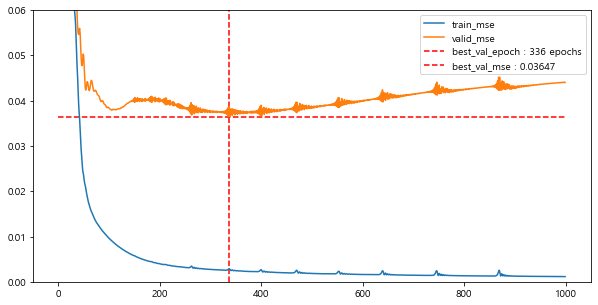

In [7]:
# cycle을 추출할 때 weighted rolling
# train에서 전부 추출 데이터로만 스케일러 학습
# time data, notime data 사용
#  인코딩 후 no time data는 곱해주기
# hiddensize = 32


plt.figure(figsize = [10, 5])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = len(train_error),
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.06)
plt.show()

In [4]:
best_model = torch.load('models/best_cycles.pkl')

In [5]:
# trend
i = 1
print("morning trend")
y = torch.cat((train_y[:,:,i], valid_y[:,:,i], test_y[:,:,i]))
zeros = torch.zeros_like(y).to(device)
print('zeros error : ',np.array((criterion(zeros, y)).cpu()))
rand_normal = torch.randn(y.shape).to(device)
print('random normal error : ',np.array((criterion(rand_normal, y)).cpu()))

morning trend
zeros error :  0.073460214
random normal error :  1.0757339


In [6]:
print("morning cycle results")

train_pred = best_model(train_time, train_notime)
print('train_error : ',criterion(train_pred, train_y[:,:,1]))

valid_pred = best_model(valid_time, valid_notime)
print('valid_error : ',criterion(valid_pred, valid_y[:,:,1]))

test_pred = best_model(test_time, test_notime)
print('test_error : ',criterion(test_pred, test_y[:,:,1]))

morning cycle results
train_error :  tensor(0.0028, device='cuda:0', grad_fn=<MseLossBackward>)
valid_error :  tensor(0.0365, device='cuda:0', grad_fn=<MseLossBackward>)
test_error :  tensor(0.0405, device='cuda:0', grad_fn=<MseLossBackward>)


In [34]:
# trend
i = 1
print("morning trend")
y = torch.cat((train_y[:,:,i], valid_y[:,:,i], test_y[:,:,i]))
zeros = torch.zeros_like(y).to(device)
print('zeros error : ',np.array((criterion(zeros, y)).cpu()))
rand_normal = torch.randn(y.shape).to(device)
print('random normal error : ',np.array((criterion(rand_normal, y)).cpu()))

morning trend
zeros error :  0.073460214
random normal error :  1.0759555


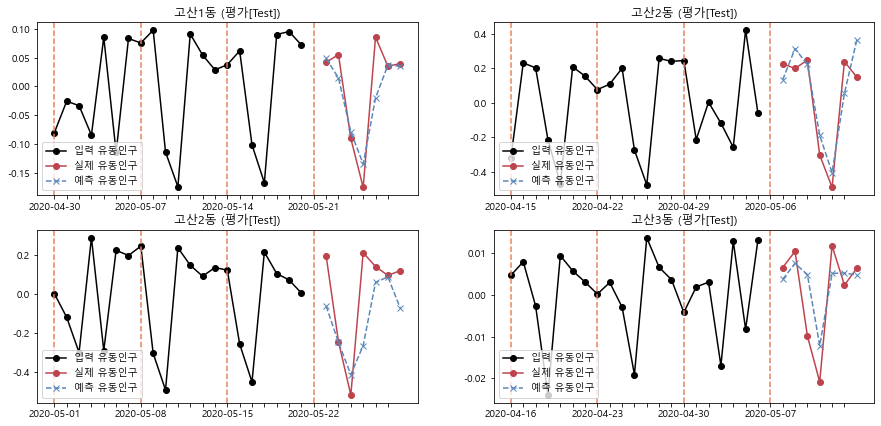

In [8]:
train_pred = best_model(train_time, train_notime)
test_pred = best_model(test_time, test_notime)

# convert result
train_x_np, train_y_np, train_pred_np,\
test_time_x_np, test_y_np, test_pred_np = tensor2numpy([train_time[:,:,-1], train_y[:,:,1], train_pred,
                                                        test_time[:,:,-1], test_y[:,:,1], test_pred])
# plot result
plot_test_predict(test_time_x_np, test_y_np, test_pred_np)

# save result
cycle_result_list = [train_x_np, train_y_np, train_pred_np,\
                    test_time_x_np, test_y_np, test_pred_np]

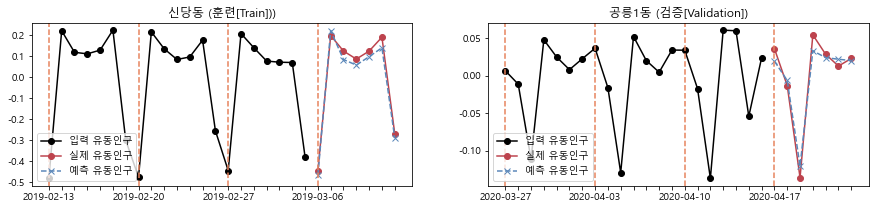

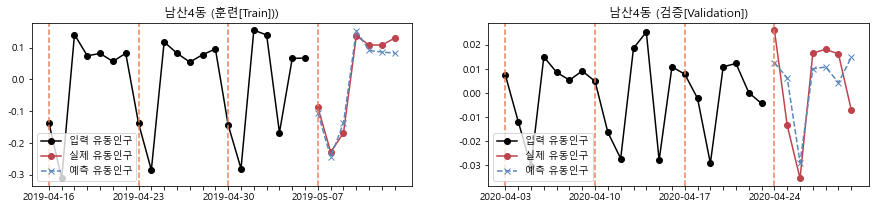

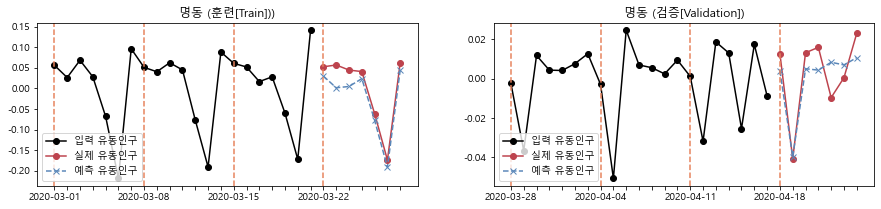

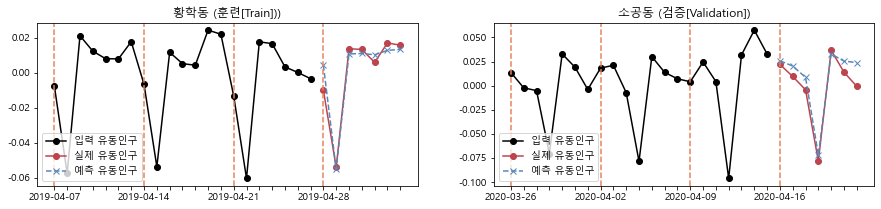

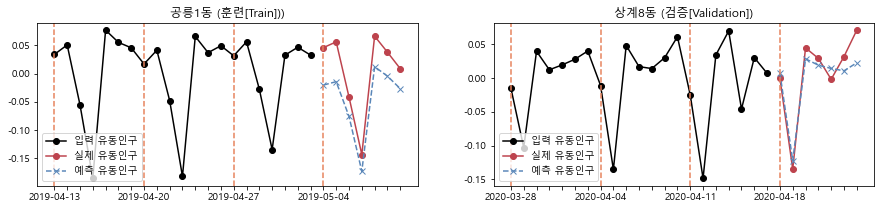

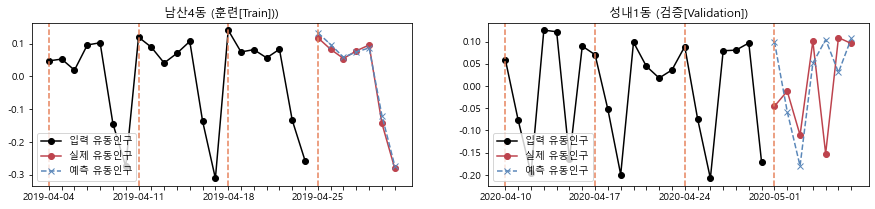

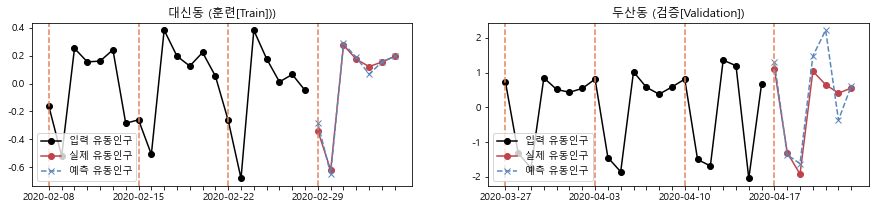

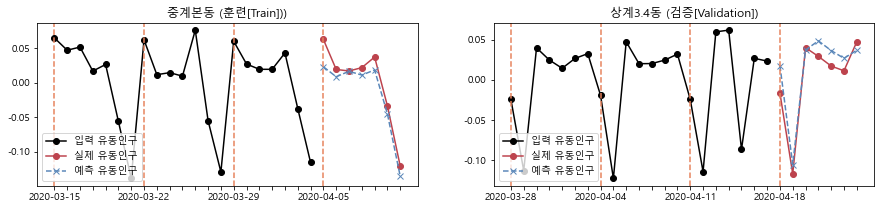

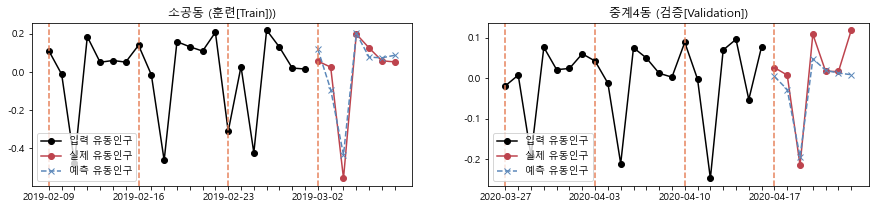

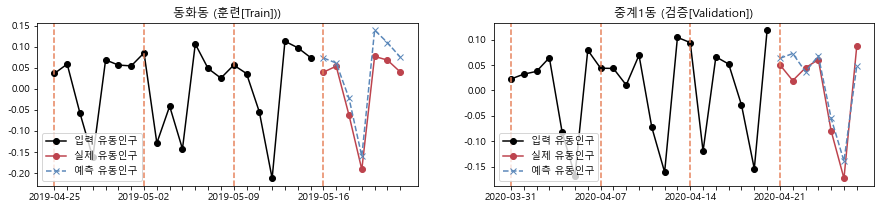

In [7]:


train_pred = best_model(train_time, train_notime)
valid_pred = best_model(valid_time, valid_notime)
# convert result
train_x_np, train_y_np, train_pred_np,\
valid_time_x_np, valid_y_np, valid_pred_np = tensor2numpy([train_time[:,:,-1], train_y[:,:,1], train_pred,
                                                        valid_time[:,:,-1], valid_y[:,:,1], valid_pred])
# plot result
plot_predict(train_x_np, train_y_np, train_pred_np,\
                valid_time_x_np, valid_y_np, valid_pred_np)

# save result
cycle_result_list = [train_x_np, train_y_np, train_pred_np,\
                    valid_time_x_np, valid_y_np, valid_pred_np]
### morning result
path = '../data/train_results/morning_results/'
with open(path + 'm_cycle_results_list.pkl', 'wb') as f:
    pickle.dump(cycle_result_list, f)

In [9]:
with open('../data/preprocess/june_data/morning_june_time.pkl', 'rb') as f:
    train_time = pickle.load(f)
with open('../data/preprocess/june_data/morning_june_notime.pkl', 'rb') as f:
    train_notime = pickle.load(f)

tc = 1
cycle_size =train_time[:,:,-2].max(axis = 1) - train_time[:,:, -2].min(axis = 1)
train_notime = np.concatenate([train_notime, cycle_size.reshape(-1,1)], axis = 1)

train_time_x, train_notime_x = numpy2tensor([train_time[:,:,3:].astype(np.float64), train_notime.astype(np.float64)])
pred_y = best_model(train_time_x, train_notime_x)
pred_y = np.array(pred_y.cpu().detach())

path = '../data/predict_june/predict_cycle_trend/'
with open(path + 'june_morning_cycle_pred.pkl', 'wb') as f:
    pickle.dump(pred_y, f)